In [1]:
# Set up interactive plotting using matplotlib, and load numpy
# %pylab ipympl
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Setup
**Note** as of PODPAC 1.2.0, this is not working, potentially due to a change

## Import PODPAC dependencies

In [2]:
import ipywidgets as widgets
import ipyleaflet as leaf
import traitlets as tl
import numpy as np
import podpac
from podpac import clinspace, crange
from podpac.datalib import smap

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html)

In [3]:
import getpass
username = input("Username:");   password = getpass.getpass('Password:')

Username: mpuecker
Password: ··················


## Create the PODPAC SMAP Node

In [4]:
# Create the SMAP node
sm = smap.SMAP(username=username, password=password)

# Create controller for execution of selected parameters

In [5]:
class ExecuteControl(tl.HasTraits):
    points = tl.List()
    regions = tl.List()
    lat_resolution = tl.Union([tl.Float(), tl.Int()], allow_none=True, default_value=None)
    lon_resolution = tl.Union([tl.Float(), tl.Int()], allow_none=True, default_value=None)
    node = tl.Instance(podpac.Node)
    ui = tl.Instance(widgets.CoreWidget)
    status = tl.Unicode()
    results = tl.List()
    
    date_picker = tl.Instance(widgets.CoreWidget)
    status_widget = tl.Instance(widgets.CoreWidget)
    attrs = tl.Instance(widgets.CoreWidget)
    resolution = tl.Instance(widgets.CoreWidget)
    
    @tl.observe('status')
    def update_ui_status(self, change):
        if not self.ui:
            return
        self.status_widget.value = self.status
        
    
    def handle_draw(self, action, geo_json):
        if action == 'created':
            self.create_geom(geo_json['geometry']['type'], geo_json['geometry']['coordinates'])
        else:
            self.delete_geom(geo_json['geometry']['type'], geo_json['geometry']['coordinates'])
            
    def create_geom(self, type, coords):
        if type == 'Point':
            self.points.append(coords)
        elif type == 'Polygon':
            self.regions.append([coords[0][1], # upper-left corner
                                coords[0][3]  # lower-right corner
            ])
            
    def delete_geom(self, type, coords):
        if type == 'Point':
            self.points.pop(self.points.index(coords))
        elif type == 'Polygon':
            self.regions.pop(self.regions.index([coords[0][1], coords[0][3]]))

    def make_coords(self):
        # Make the time coordinates
        time = self.make_time_coords()
        if not time:
            return []
        
        ignore_end_for_regions = execute_control.date_picker.children[1].children[1].value
        time_r = time
        if ignore_end_for_regions:
            time_r = self.make_time_coords(True)
        
        if self.points:
            points = [podpac.coordinates.merge_dims([podpac.Coordinates([np.array(self.points)[:,::-1].T], ['lat_lon']),  time])]
        else: 
            points = []
        rasters = []
        if self.regions:
            for r in self.regions:
                if self.lat_resolution:
                    lat = podpac.Coordinates([crange(r[0][1], r[1][1], self.lat_resolution)], ['lat'])
                else: 
                    lat = self.node.find_coordinates()[0].intersect(podpac.Coordinates([clinspace(r[0][1], r[1][1], 2)] , ['lat']))
                    lat = lat.drop(['lon', 'time'])
                if self.lon_resolution:
                    lon = podpac.Coordinate([crange(r[0][0], r[1][0], self.lon_resolution)], ['lon'])
                else: 
                    lon = self.node.find_coordinates()[0].intersect(podpac.Coordinates([crange(r[0][0], r[1][0], 2)], ['lon']))
                    lon = lon.drop(['lat', 'time'])
                rasters.append(podpac.coordinates.merge_dims([lat, lon, time_r]))
        return points + rasters
    
    def make_time_coords(self, ignore_end=False):
        if not self.ui: 
            return []
        date_picker = self.date_picker
        date_start = date_picker.children[0].value
        date_end = date_picker.children[1].children[0].value
        date_step = date_picker.children[2].children[0].value
        date_step_type = date_picker.children[2].children[1].value
        
        if not date_start:
            return []
        
        date = str(np.datetime64(date_start)) +'T00'
        if not date_end or ignore_end: 
            date = np.datetime64(date_start)
            return podpac.Coordinates([date], ['time'])
        date_end = str(np.datetime64(date_end)) +'T00'
        if date_step_type == 'native':
            window = podpac.Coordinates([clinspace(date, date_end, 2)], ['time'])
            time = self.node.find_coordinates()[0].intersect(window)
            time = time.drop(['lat', 'lon'])
            return time
        elif date_step_type == '#':
            return podpac.Coordinates([crange(date, date_end, date_step)], ['time'])
        
        ds = '%d,%s' % (date_step, date_step_type)
        return podpac.Coordinates([crange(date, date_end, ds)], ['time'])
    
    def set_node_attrs(self):
        if not self.ui: 
            return False
        attrs = self.attrs
        self.node.set_trait('product', attrs.children[0].value)
        self.node.set_trait('interpolation', attrs.children[1].value)
        return True
    
    def execute(self, button):
        self.status = 'Executing...'
        if not self.set_node_attrs():
            self.status = "Node attributes (product, interpolation) not set correctly."
        
        # Set the resolution of the lat/lon
        self.lat_resolution = execute_control.resolution.children[1].value
        self.lon_resolution = execute_control.resolution.children[2].value
        try: 
            coords = self.make_coords()
        except Exception as e:
            self.status = 'Unknown Error: ' + str(e)
            return
        if not coords:
            self.status = 'Coords not fully specified'
            return
        
        self.results = []
        i = 0
        for c in coords:
#             if i == 0 and self.points:
#                 self.node.threaded = True
#                 self.node.n_threads = 4
            try:
                self.results.append(self.node.eval(c))
            except Exception as e:
                self.status = 'Unknown Error: ' + str(e)
                return
                
#             self.node.threaded = False
            i += 1
        self.status = "Execution complete"
        
        # Update figures
        figure(1)
        subplot(121)
        cla()
        if self.points:
            if not np.isnan(self.results[0].mean()):
                plot(self.results[0].time, self.results[0].data.T)
                legend([str([llp.data['lat'].item(), llp.data['lon'].item()]) for llp in self.results[0].lat_lon])
                locs, labels = xticks()
                xticks(locs[::2])
                axis('auto')
        else:
            self.results[0][..., -1].plot(cmap='gist_earth_r')
            axis('scaled')
        figure(1)
        subplot(122)
        cla()
        if len(self.results) > 1:
            self.results[1][..., -1].plot(cmap='gist_earth_r')
            axis('scaled')
        
    
execute_control = ExecuteControl(node=sm)

# Create UI View elements (widgets)
## Create widget for picking dates

In [6]:
# Create a widget for the date picker
layout = widgets.Layout(display='flex',
                       align_items='stretch',
#                        border='solid',
#                        width='50%'
                       )
date_start = widgets.DatePicker(description='Date start', layout=layout)
date_end = widgets.DatePicker(description='Date end', layout=layout)
ignore_end = widgets.Checkbox(description='Ignore for regions', indent=False, layout=layout, value=True)
date_end_group = widgets.HBox(children=[date_end, ignore_end], layout=layout)

date_step_val  = widgets.IntText(description='Step value', layout=layout, min=0, step=1)
date_step_type = widgets.Dropdown(description='Step type', options=['native', '#', 's', 'm', 'h', 'D', 'M', 'Y'], layout=layout)
date_step = widgets.HBox(children=[date_step_val, date_step_type], layout=layout)

date_picker = widgets.VBox(children=[date_start, date_end_group, date_step], layout=layout)
execute_control.date_picker = date_picker
date_picker

## Create widget for selecting SMAP product and interpolation type

In [7]:
# Create a widget for selecting the SMAP product and interpolation
product_list = smap.SMAP_PRODUCT_MAP.product.data.tolist()
product_list.sort()
smap_product = widgets.Dropdown(description="Product", options=product_list, value='SPL4SMAU')
# smap_product
interpolation = widgets.Dropdown(description="Interpolation", options=['nearest', 'bilinear', 'cubic'])
smap_attrs = widgets.VBox(children=[smap_product, interpolation])
execute_control.attrs = smap_attrs
smap_attrs

## Create widget for specifying spatial resolution

In [8]:
# Create widget for specifying lat, lon coordinate resolutions
style = {'description_width': 'initial'}
lat_res = widgets.FloatText(description='Latitude', value=0, min=0, step=0.1, max=180)
lon_res = widgets.FloatText(description='Longitude', value=0, min=0, step=0.1, max=180)
title_res = widgets.HTML('<em>Resolution</em>')
resolution = widgets.VBox(children=[title_res, lat_res, lon_res], description='Resolution')
execute_control.resolution = resolution
resolution

## Create ipyleaflet widgets for selecting regions of the map

In [9]:
lmap = leaf.Map(zoom=2, scroll_wheel_zoom=True)
dc = leaf.DrawControl(marker={'shapeOptions': {'color': '#00FF00', 'fillOpacity': 0.5}},
                      rectangle={'shapeOptions': {'color': '#0000FF', 'fillOpacity': 0.25, 'fillColor':'#00FF00', 'weight': 1}},
                      circle={},
                      circlemarker={},
                      polyline={},
                      polygon={}, 
                      edit=False
                 )
def handle_draw(self, action, geo_json):
    execute_control.handle_draw(action, geo_json)
dc.on_draw(handle_draw)
lmap.add_control(dc)
lmap.layout.height = '500px'
lmap.layout.flex = 'none'

#lmap

## Put the UI elements together

In [10]:
# Put the UI elements together
execute_button = widgets.Button(description='Execute')
execute_button.on_click(execute_control.execute)
status = widgets.Text(description='Status:', disabled=True)
execute_control.status_widget = status
section = widgets.VBox(children=[execute_button, status])
ui_top = widgets.HBox(children=[section, smap_attrs, date_picker, resolution])
ui = widgets.VBox(children=[ui_top, lmap])
execute_control.ui = ui

# Display the UI

In [11]:
# Display the ui
ui

# Display some of the results

(-0.05, 1.05, -0.05, 1.05)

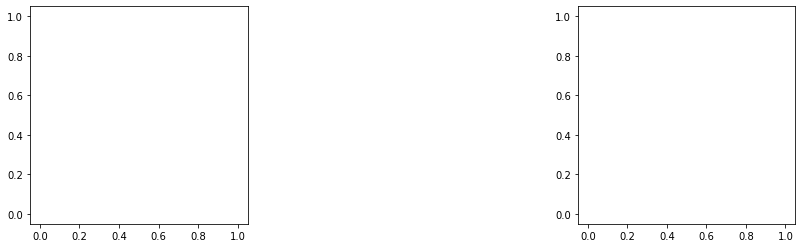

In [12]:
close(1);figure(1, figsize=(18, 4)); subplot(121); axis('scaled'); subplot(122); axis('scaled')